# 1. EDA for data from MyAnimeList

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import spacy

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess, lemmatize
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from wordcloud import WordCloud


pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', None)

%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [2]:
#read the file
#os.chdir('C:/Users/weiji/OneDrive/Desktop/BT5153 Applied Machine Learning/group project/data')

maldf = pd.read_csv('dataset_full.csv', encoding = 'utf-8')

In [3]:
maldf.head()

,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['Wit Studio'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.10,#4,#67,1016919,38564,2019-04-29,2019-04-29,649250.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Seeking to restore humanity’s diminishing hope...,['Shingeki no Kyojin Season 3'],NaN,['Shingeki no Kyojin: The Final Season'],NaN,['Shingeki no Kyojin: Chronicle'],NaN,NaN,NaN
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,Wednesdays at 18:00 (JST),"['TV Tokyo', 'Aniplex', 'Dentsu']","['Funimation', 'Crunchyroll']",['Bandai Namco Pictures'],Manga,"['Action', 'Comedy', 'Historical', 'Parody', '...",24,PG-13 - Teens 13 or older,9.10,#5,#327,397055,11689,2015-04-08,2015-04-08,139516.0,['Gintama'],NaN,['Gintama°: Umai-mono wa Atomawashi ni Suru to...,NaN,"Gintoki, Shinpachi, and Kagura return as the f...",['Gintama Movie 2: Kanketsu-hen - Yorozuya yo ...,NaN,['Gintama.'],NaN,NaN,NaN,NaN,NaN


In [4]:
maldf['Title'].nunique()

17476

In [5]:
#check number of nulls in score column

print (f"The number of missing values in Score Column is: {maldf['Score'].isnull().sum():.0f}")


print (f"The number of values in Score Column is: {maldf['Score'].notnull().sum():.0f}")


The number of missing values in Score Column is: 5125
The number of values in Score Column is: 12364


In [6]:
maldf['Genres'].dtype

dtype('O')

In [7]:
#string split the values in the genres column into multiple columns with 'Genre_' as prefix
maldf2 = maldf.join(maldf['Genres'].str.split(',',expand=True).add_prefix('Genre_').fillna(np.nan))
 


In [8]:
maldf2.head()

,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['Action','Military','Adventure','Comedy','Drama','Magic','Fantasy','Shounen'],NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,['Action','Military','Mystery','Super Power','Drama','Fantasy','Shounen'],NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN,['Thriller','Sci-Fi'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['Wit Studio'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.10,#4,#67,1016919,38564,2019-04-29,2019-04-29,649250.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Seeking to restore humanity’s diminishing hope...,['Shingeki no Kyojin Season 3'],NaN,['Shingeki no Kyojin: The Final Season'],NaN,['Shingeki no Kyojin: Chronicle'],NaN,NaN,NaN,['Action','Military','Mystery','Super Power','Drama','Fantasy','Shounen'],NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,Wednesdays at 18:00 (JST),"['TV Tokyo', 'Aniplex', 'Dentsu']","['Funimation', 'Crunchyroll']",['Bandai Namco Pictures'],Manga,"['Action', 'Comedy', 'Historical', 'Parody', '...",24,PG-13 - Teens 13 or older,9.1

In [9]:
maldf2['Title'].nunique()

17476

## 1.1 Explore Genre Data

In [10]:
#select all the genre columns
genre_col = [col for col in maldf2 if col.startswith('Genre_')]
genre_col

['Genre_0',
 'Genre_1',
 'Genre_2',
 'Genre_3',
 'Genre_4',
 'Genre_5',
 'Genre_6',
 'Genre_7',
 'Genre_8',
 'Genre_9',
 'Genre_10',
 'Genre_11',
 'Genre_12']

In [11]:
#remove punctuation in selected genre columns
#maldf2[genre_col] = maldf2[genre_col].replace(r'[^\w\s]', '', regex=True)

#create a list of punctuation to remove
punctuation = ["\[", "\]" ,"\'"] 


for i in punctuation:
    maldf2[genre_col] = maldf2[genre_col].replace(i,"", regex=True)


In [12]:
maldf2.head()

,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN,Thriller,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['Wit Studio'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.10,#4,#67,1016919,38564,2019-04-29,2019-04-29,649250.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Seeking to restore humanity’s diminishing hope...,['Shingeki no Kyojin Season 3'],NaN,['Shingeki no Kyojin: The Final Season'],NaN,['Shingeki no Kyojin: Chronicle'],NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,Wednesdays at 18:00 (JST),"['TV Tokyo', 'Aniplex', 'Dentsu']","['Funimation', 'Crunchyroll']",['Bandai Namco Pictures'],Manga,"['Action', 'Comedy', 'Historical', 'Parody', '...",24,PG-13 - Teens 13 or older,9.10,#5,#327,397055,11689,2015-04-08,2015-04-08,139516.0,['

In [13]:
#strip values in genre cols of whitespace
maldf2[genre_col] = maldf2[genre_col].apply(lambda x: x.str.strip())

In [14]:
#unpivot from genre values from wide to long using melt
genscore = maldf2.filter(regex=r'Score|Genre_').melt('Score', value_name='Genre')


In [15]:
#use a dictionary for groupby

genscore_dict = {'Value_Count': ('Genre', 'count'), 'Average_Score': ('Score', 'mean')}
genscore_df = genscore.groupby('Genre', as_index=False).agg(**genscore_dict)
genscore_df

,Genre,Value_Count,Average_Score
0,Action,3865,6.754483
1,Adventure,2950,6.758087
2,Cars,132,6.532154
3,Comedy,6009,6.708433
4,Dementia,510,5.256141
5,Demons,494,6.730165
6,Drama,2616,6.981444
7,Ecchi,768,6.488529
8,Fantasy,3258,6.679902
9,Game,385,6.581900


In [16]:
#get top 10 based on count and average score
genscore_top10 = genscore_df.sort_values(['Value_Count','Average_Score'], ascending=False).head(10)

genscore_top10

,Genre,Value_Count,Average_Score
3,Comedy,6009,6.708433
0,Action,3865,6.754483
8,Fantasy,3258,6.679902
1,Adventure,2950,6.758087
15,Kids,2662,6.254003
6,Drama,2616,6.981444
29,Sci-Fi,2575,6.645504
20,Music,2230,6.099484
33,Shounen,1995,7.039966
35,Slice of Life,1898,6.844809


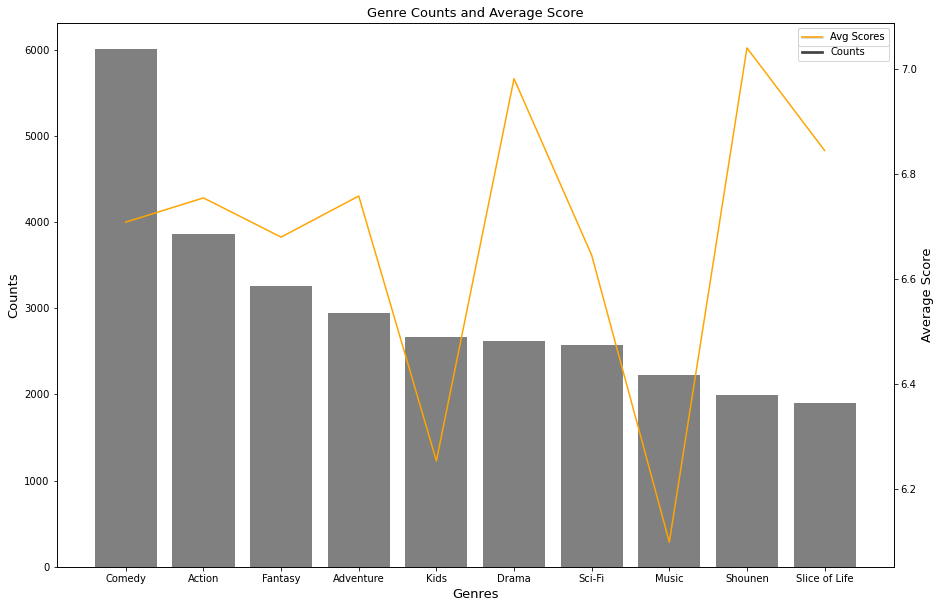

In [17]:
#plot the rating counts


fig, ax1 = plt.subplots(figsize=(15,10))

#bar plot creation
ax1.set_title('Genre Counts and Average Score', fontsize = 13)
ax1 = sns.barplot(x='Genre',y='Value_Count', data = genscore_top10, color='grey', label = 'Counts')
ax1.set_xlabel('Genres', fontsize = 13)
ax1.set_ylabel('Counts', fontsize = 13)
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
#line plot creation
ax2 = sns.lineplot(x= 'Genre', y='Average_Score', data=genscore_top10, color = 'orange', label = 'Avg Scores')
ax2.set_ylabel('Average Score', fontsize = 13)

ax2.tick_params(axis='y')

ax1.legend(loc='upper right', labels=['Avg Scores','Counts'])
plt.show()


#plt.tight_layout();

In [18]:
#plotting genres with threshold
genre_threshold = 500
genscore_df['Cross_Threshold'] = (genscore_df['Value_Count'] > genre_threshold)

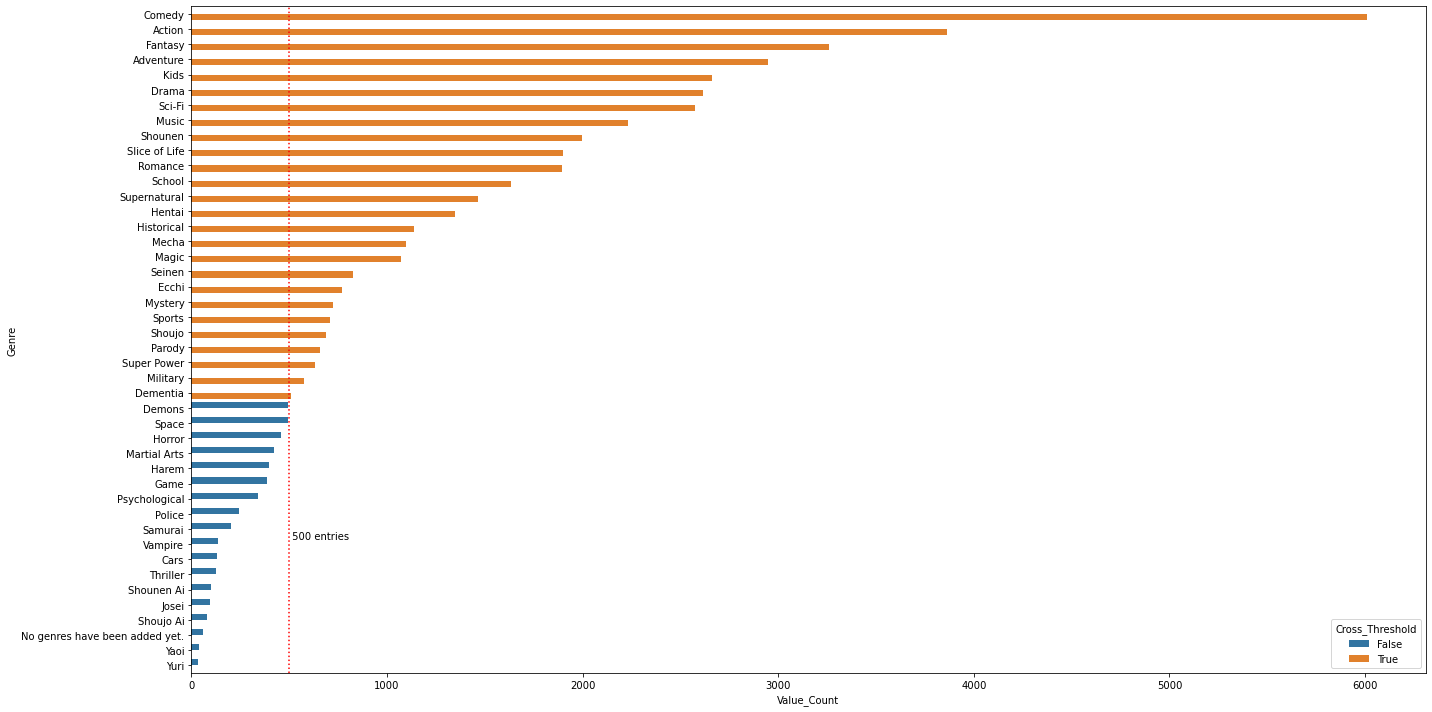

In [19]:
#plot the genre counts
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=genscore_df.sort_values('Value_Count', ascending=False), y='Genre', x='Value_Count', hue='Cross_Threshold', ax=ax)
plt.axvline(genre_threshold, color='red', linestyle=':')
plt.text(genre_threshold, 0.2, " " + str(genre_threshold) + " entries", transform=ax.get_xaxis_transform())
plt.tight_layout();

## 1.2 Explore ratings data

In [20]:
#get rating counts

rating_counts = maldf2['Rating'].value_counts().rename_axis('Rating').reset_index(name='Count')



In [21]:
rating_counts

,Rating,Count
0,PG-13 - Teens 13 or older,6112
1,G - All Ages,5779
2,PG - Children,1453
3,Rx - Hentai,1344
4,R - 17+ (violence & profanity),1151
5,R+ - Mild Nudity,996
6,None,654


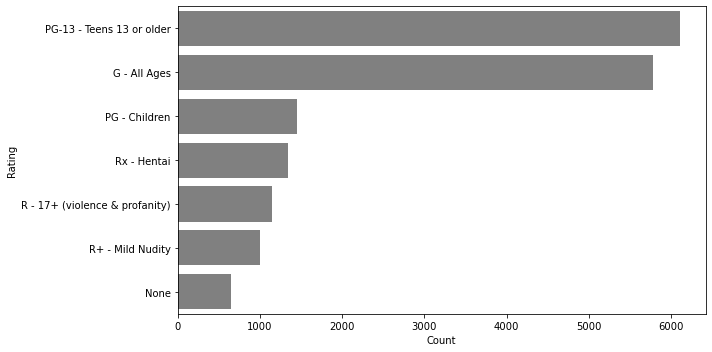

In [22]:
#plot the rating counts
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=rating_counts.sort_values('Count', ascending=False), y='Rating', x='Count', color='grey', ax=ax)
plt.tight_layout();

In [23]:
#get duration that each anime aired for

maldf2[['Air_Start', 'Air_End']] = maldf2['Aired'].str.split('to', 1, expand=True)


In [24]:
#convert to date time dtype
maldf2[['Air_Start','Air_End']] = maldf2[['Air_Start','Air_End']].apply(pd.to_datetime, errors='coerce')


In [25]:
#calculate duration aired for each anime
maldf2['Duration_Aired'] = (maldf2['Air_End'] - maldf2['Air_Start']) / np.timedelta64(1, 'Y')
maldf2['Duration_Aired'] = maldf2['Duration_Aired'].round(2)

In [26]:
maldf2.head()

,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Air_Start,Air_End,Duration_Aired
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,2009-04-05,2010-07-04,1.25
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-07,NaT,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN,Thriller,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-06,2011-09-14,0.44
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['Wit Studio'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.10,#4,#67,1016919,38564,2019-04-29,2019-04-29,649250.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Seeking to restore humanity’s diminishing hope...,['Shingeki no Kyojin Season 3'],NaN,['Shingeki no Kyojin: The Final Season'],NaN,['Shingeki no Kyojin: Chronicle'],NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-29,2019-07-01,0.17
4,4,4,Gintama°,https://myanimelist.net/anime/28977/Gintama°,Gintama Season 4,Gintama' (2015),銀魂°,TV,51.0,Finished Airing,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,Wednesdays at 18:00 (JST),"['TV Tokyo', 'Aniplex', 'Dentsu']","['Funimation', 'Crunchyroll']",['Bandai Namco Pictures'],Manga,"['Acti

Text(0.5, 0, 'Number of years anime aired for')

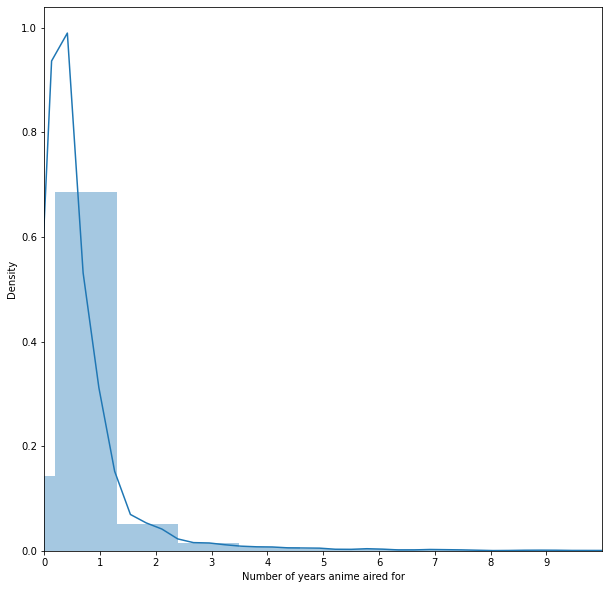

In [27]:
#plot distribution of 
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(0,10)
plt.xticks(np.arange(0, 10, 1))

sns.distplot(maldf2['Duration_Aired'])
plt.xlabel('Number of years anime aired for')


## 1.3 Explore producer data

In [28]:
#string split the values in the producers column into multiple columns with 'Producer_' as prefix
maldf3 = maldf2.join(maldf2['Producers'].str.split(',',expand=True).add_prefix('Producer_').fillna(np.nan))

In [29]:
#select all the producer columns
prod_col = [col for col in maldf3 if col.startswith('Producer_')]
prod_col

['Producer_0',
 'Producer_1',
 'Producer_2',
 'Producer_3',
 'Producer_4',
 'Producer_5',
 'Producer_6',
 'Producer_7',
 'Producer_8',
 'Producer_9',
 'Producer_10',
 'Producer_11',
 'Producer_12',
 'Producer_13',
 'Producer_14',
 'Producer_15',
 'Producer_16',
 'Producer_17',
 'Producer_18',
 'Producer_19']

In [30]:
maldf3.head(100)

,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Air_Start,Air_End,Duration_Aired,Producer_0,Producer_1,Producer_2,Producer_3,Producer_4,Producer_5,Producer_6,Producer_7,Producer_8,Producer_9,Producer_10,Producer_11,Producer_12,Producer_13,Producer_14,Producer_15,Producer_16,Producer_17,Producer_18,Producer_19
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,2009-04-05,2010-07-04,1.25,['Aniplex','Square Enix','Mainichi Broadcasting System','Studio Moriken'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-07,NaT,NaN,['Production I.G','Dentsu','Mainichi Broadcasting System','Pony Canyon','Kodansha','Techno Sound','Pony Canyon Enterprise'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN,Thriller,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-06,2011-09-14,0.44,['Frontier Works','Media Factory','Movic','AT-X','Kadokawa Pictures Japan','Nitroplus'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['Wit Studio'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence

In [31]:
#create a list of punctuation to remove
punctuation = ["\[", "\]" ,"\'", '\"'] 


for i in punctuation:
    maldf3[prod_col] = maldf3[prod_col].replace(i,"", regex=True)



In [32]:
#strip values in genre cols of whitespace
maldf3[prod_col] = maldf3[prod_col].apply(lambda x: x.str.strip())

In [33]:
#unpivot from genre values from wide to long using melt
prodscore = maldf3.filter(regex=r'Score|Producer_').melt('Score', value_name='Producer')


In [34]:
#use a dictionary for groupby

prodscore_dict = {'Value_Count': ('Producer', 'count'), 'Average_Score': ('Score', 'mean')}
prodscore_df = prodscore.groupby('Producer', as_index=False).agg(**prodscore_dict)
prodscore_df

,Producer,Value_Count,Average_Score
0,,7761,6.267421
1,12 Diary Holders,1,7.560000
2,1st PLACE,1,7.080000
3,1theK,2,NaN
4,3xCube,1,7.190000
...,...,...,...
1300,project lights,1,5.460000
1301,studioGONG,1,6.920000
1302,syn Sophia,1,6.560000
1303,teamKG,1,5.820000


In [35]:
prodscore_df['Producer'].nunique()

1305

In [36]:
#sort values by average score
prodscore_top10 = prodscore_df.sort_values(['Value_Count','Average_Score'], ascending=False).head(10)

prodscore_top10

,Producer,Value_Count,Average_Score
0,,7761,6.267421
713,NHK,715,6.374250
82,Aniplex,492,7.409958
1100,TV Tokyo,476,7.041193
606,Lantis,443,7.016697
150,Bandai Visual,416,7.019975
371,Fuji TV,332,7.157500
699,Movic,324,7.170062
827,Pony Canyon,315,6.967153
978,Sotsu,302,6.980692


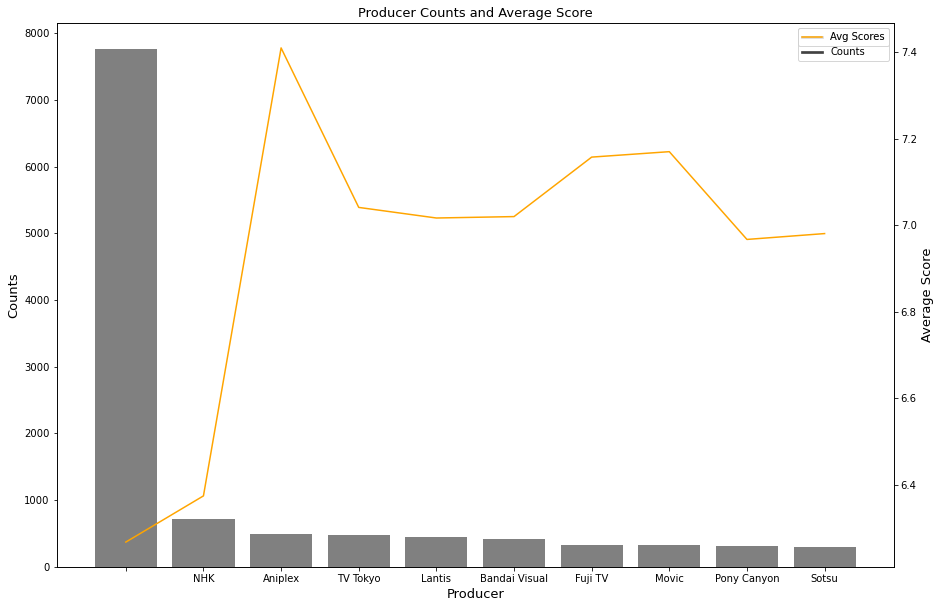

In [37]:
#plot the producer counts


fig, ax1 = plt.subplots(figsize=(15,10))

#bar plot creation
ax1.set_title('Producer Counts and Average Score', fontsize = 13)
ax1 = sns.barplot(x='Producer',y='Value_Count', data = prodscore_top10, color='grey', label = 'Counts')
ax1.set_xlabel('Producer', fontsize = 13)
ax1.set_ylabel('Counts', fontsize = 13)
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
#line plot creation
ax2 = sns.lineplot(x= 'Producer', y='Average_Score', data=prodscore_top10, color = 'orange', label = 'Avg Scores')
ax2.set_ylabel('Average Score', fontsize = 13)

ax2.tick_params(axis='y')

ax1.legend(loc='upper right', labels=['Avg Scores','Counts'])
plt.show()



In [38]:
# test = maldf3[maldf3[prod_col].apply(pd.Series.mean('Score'))]

## 1.4 Explore data for Studio

In [39]:
#string split the values in the producers column into multiple columns with 'Studio_' as prefix
maldf4 = maldf3.join(maldf3['Studios'].str.split(',',expand=True).add_prefix('Studio_').fillna(np.nan))

In [40]:
maldf4.head(100)

,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Air_Start,Air_End,Duration_Aired,Producer_0,Producer_1,Producer_2,Producer_3,Producer_4,Producer_5,Producer_6,Producer_7,Producer_8,Producer_9,Producer_10,Producer_11,Producer_12,Producer_13,Producer_14,Producer_15,Producer_16,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,2009-04-05,2010-07-04,1.25,Aniplex,Square Enix,Mainichi Broadcasting System,Studio Moriken,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['Bones'],NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-07,NaT,NaN,Production I.G,Dentsu,Mainichi Broadcasting System,Pony Canyon,Kodansha,Techno Sound,Pony Canyon Enterprise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['MAPPA'],NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN,Thriller,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-06,2011-09-14,0.44,Frontier Works,Media Factory,Movic,AT-X,Kadokawa Pictures Japan,Nitroplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['White Fox'],NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', '

In [41]:
#select all the producer columns
stud_col = [col for col in maldf4 if col.startswith('Studio_')]
stud_col

['Studio_0',
 'Studio_1',
 'Studio_2',
 'Studio_3',
 'Studio_4',
 'Studio_5',
 'Studio_6']

In [42]:
#create a list of punctuation to remove
punctuation = ["\[", "\]" ,"\'", '\"'] 


for i in punctuation:
    maldf4[stud_col] = maldf4[stud_col].replace(i,"", regex=True)

In [43]:
#strip values in stud cols of whitespace
maldf4[stud_col] = maldf4[stud_col].apply(lambda x: x.str.strip())

In [44]:
#unpivot from genre values from wide to long using melt
studscore = maldf4.filter(regex=r'Score|Studio_').melt('Score', value_name='Studio')

In [45]:
#use a dictionary for groupby

studscore_dict = {'Value_Count': ('Studio', 'count'), 'Average_Score': ('Score', 'mean')}
studscore_df = studscore.groupby('Studio', as_index=False).agg(**studscore_dict)
studscore_df

,Studio,Value_Count,Average_Score
0,,7054,5.84994
1,10Gauge,6,6.65500
2,1IN,1,NaN
3,2:10 AM Animation,6,7.23000
4,33 Collective,1,NaN
...,...,...,...
712,monofilmo,2,7.34000
713,pH Studio,6,6.26000
714,production doA,4,7.06500
715,teamKG,3,6.24000


In [46]:
studscore_top10 = studscore_df.sort_values(['Value_Count','Average_Score'], ascending=False).head(10)

studscore_top10

,Studio,Value_Count,Average_Score
0,,7054,5.849940
633,Toei Animation,778,6.728027
588,Sunrise,499,6.913831
259,J.C.Staff,380,6.830809
321,Madhouse,364,6.979803
431,Production I.G,335,7.037788
600,TMS Entertainment,300,7.074690
530,Studio Deen,287,6.989885
561,Studio Pierrot,262,6.846667
371,OLM,236,6.620966


In [47]:
studscore_df['Studio'].nunique()

717

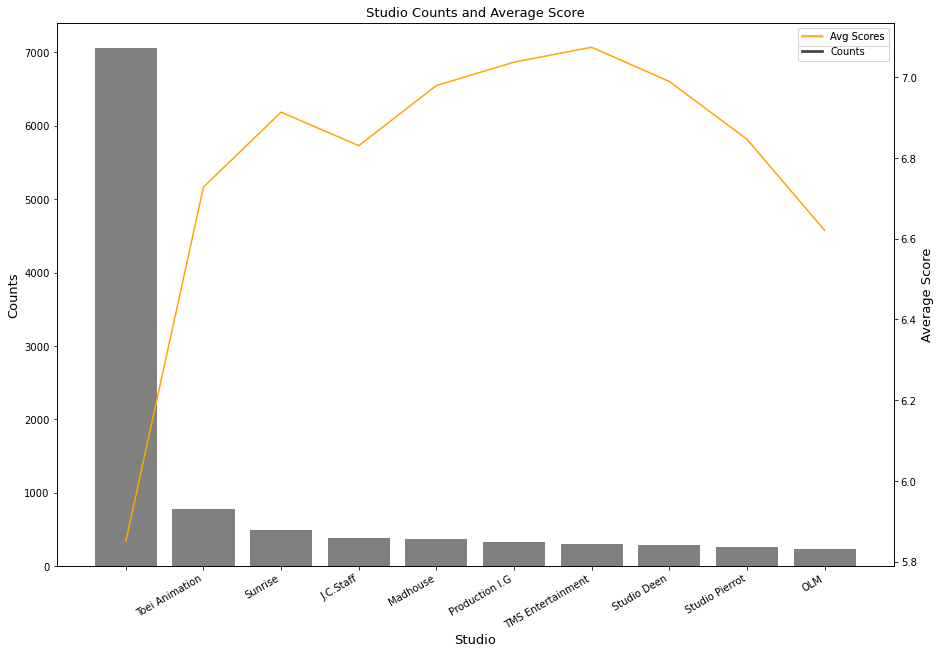

In [48]:
#plot the producer counts


fig, ax1 = plt.subplots(figsize=(15,10))

#bar plot creation
ax1.set_title('Studio Counts and Average Score', fontsize = 13)
ax1 = sns.barplot(x='Studio',y='Value_Count', data = studscore_top10, color='grey', label = 'Counts')
ax1.set_xlabel('Studio', fontsize = 13)
ax1.set_ylabel('Counts', fontsize = 13)
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
#line plot creation
ax2 = sns.lineplot(x= 'Studio', y='Average_Score', data=studscore_top10, color = 'orange', label = 'Avg Scores')
ax2.set_ylabel('Average Score', fontsize = 13)

ax2.tick_params(axis='y')

ax1.legend(loc='upper right', labels=['Avg Scores','Counts'])

plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# 2 NLP for Anime Synopsis

In [49]:
#create a copy of maldf4
maldf5 = maldf4.copy()

In [50]:
maldf5.head()

,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Air_Start,Air_End,Duration_Aired,Producer_0,Producer_1,Producer_2,Producer_3,Producer_4,Producer_5,Producer_6,Producer_7,Producer_8,Producer_9,Producer_10,Producer_11,Producer_12,Producer_13,Producer_14,Producer_15,Producer_16,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6
0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,2009-04-05,2010-07-04,1.25,Aniplex,Square Enix,Mainichi Broadcasting System,Studio Moriken,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bones,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-07,NaT,NaN,Production I.G,Dentsu,Mainichi Broadcasting System,Pony Canyon,Kodansha,Techno Sound,Pony Canyon Enterprise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAPPA,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN,Thriller,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-06,2011-09-14,0.44,Frontier Works,Media Factory,Movic,AT-X,Kadokawa Pictures Japan,Nitroplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,White Fox,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,Attack on Titan Season 3 Part 2,NaN,進撃の巨人 Season3 Part.2,TV,10.0,Finished Airing,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Bro

## 2.1 Text pre processing

In [51]:
#number of counts for no synopsis information text
maldf5['Synopsis'].str.count("No synopsis information has been added to this title. Help improve our database by adding a synopsis here.| No synopsis has been added for this series yet.").sum()

832

In [52]:
#remove blank synopsis

noinfo = ('No synopsis information has been added to this title. Help improve our database by adding a synopsis here.', 
     'No synopsis has been added for this series yet.')

#check if the blank info is in a list
string_check = maldf5['Synopsis'].map(lambda x: x if not isinstance(x, list) else x[0])
#check if the values match the noinfo 
string_check = string_check.map(lambda s: any(noinfo_str in s for noinfo_str in noinfo))

#change the noinfo strings to blank
maldf5.loc[string_check, 'Synopsis'] = ""

In [53]:
maldf5.tail(50)

,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Air_Start,Air_End,Duration_Aired,Producer_0,Producer_1,Producer_2,Producer_3,Producer_4,Producer_5,Producer_6,Producer_7,Producer_8,Producer_9,Producer_10,Producer_11,Producer_12,Producer_13,Producer_14,Producer_15,Producer_16,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6
17439,17439,39,Kyuukyoku no Sex Adventure Kamasutra,https://myanimelist.net/anime/3910/Kyuukyoku_n...,Kama Sutra,"Kama Sutra Kyuukyoku no Sex Adventure, Kyukiok...",究極のSEXアドベンチャー カーマスートラ,OVA,1.0,Finished Airing,"Apr 24, 1992",NaN,NaN,['Toho'],[],['animate Film'],Manga,"['Action', 'Comedy', 'Romance', 'Hentai', 'Sup...",42,Rx - Hentai,4.81,NaN,#9591,1458,4,1992-04-24,NaN,502.0,['Kamasutra'],NaN,NaN,NaN,Hidden deep in the ancient Himalayan Mountains...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Comedy,Romance,Hentai,Supernatural,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1992-04-24,NaT,NaN,Toho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,animate Film,NaN,NaN,NaN,NaN,NaN,NaN
17440,17440,40,Punky Funky Baby,https://myanimelist.net/anime/12563/Punky_Funk...,Punky Funky Baby,"Synphony Yume Monogatari, Symphony Yume Monoga...",パンキー ファンキー ベイビー,OVA,1.0,Finished Airing,"May 1, 1985",NaN,NaN,[],[],[],Unknown,['Hentai'],25,Rx - Hentai,4.80,NaN,#11809,558,0,1985-05-01,NaN,172.0,NaN,NaN,NaN,NaN,Part of Little Mermaid Series along with Telep...,NaN,NaN,NaN,"['Telepathist IQ Saiko', 'Suashi no Houkago', ...",NaN,NaN,NaN,NaN,Hentai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985-05-01,NaT,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17441,17441,41,Yayoi,https://myanimelist.net/anime/5561/Yayoi,NaN,Police Girl Yayoi,弥生,OVA,1.0,Finished Airing,"Dec 28, 1997",NaN,NaN,[],[],[],Unknown,['Hentai'],7,Rx - Hentai,4.79,NaN,#10925,798,1,1997-12-28,NaN,273.0,NaN,NaN,NaN,NaN,Doujin video produced by noted ero mangaka and...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hentai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-12-28,NaT,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17442,17442,42,Prima Donna Mai,https://myanimelist.net/anime/6903/Prima_Donna...,NaN,NaN,プリマドンナ舞,OVA,1.0,Finished Airing,"Dec 21, 2001",NaN,NaN,['Obtain Future'],[],[],Unknown,['Hentai'],28,Rx - Hentai,4.76,NaN,#10651,896,1,2001-12-21,NaN,256.0,NaN,NaN,NaN,NaN,Mai and her gymnastics trainer are secretly in...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hentai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-21,NaT,NaN,Obtain Future,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17443,17443,43,Injuu Nerawareta Idol,https://myanimelist.net/anime/3584/Injuu_Neraw...,Idol of Darkness,NaN,淫獣 ねらわれたアイドル,OVA,1.0,Finished Airing,"Jul 2, 1997 to Jun 2, 1997",NaN,NaN,['Pink Pineapple'],['SoftCel Pictures'],[],Unknown,"['Demons', 'Hentai']",45,Rx - Hentai,4.75,NaN,#10089,1153,2,1997-07-02,1997-07-02,410.0,NaN,NaN,NaN,NaN,Ikumi is an up and coming pop singer with mill...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Demons,Hentai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-07-02,1997-06-02,-0.08,Pink Pineapple,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
17444,17444,44,Kaguya-hime: Taketori Monogatari,https://myanimelist.net/anime/14471/Kaguya-him...,NaN,Kaguyahime: Taketori Monogatari,かぐや姫 竹取物語,OVA,1.0,Finished Airing,"Sep 21, 1987",NaN,NaN,[],[],[],Unknown,"['Hentai', 'Historic

In [54]:
#remove the strings [Written by] and (Produced:) at the end of the string.
#following code replaces zero or more characters in between a [] or a () with blankspace

maldf5['Synopsis'] = maldf5['Synopsis'].str.replace(r'\s*(?:\[[^][]*]|\([^()]*\))\s*$', '')

In [55]:
# First convert all reviews into a list
data = maldf5['Synopsis'].values.tolist()
data[:20]

['"In order for something to be obtained, something of equal value must be lost."\n\nAlchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward\'s right arm that he is able to affix Alphonse\'s soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called "automail" and become a state alchemist, the Fullmetal Alchemist.\n\nThree years of searching later, the brothers seek the Philosopher\'s Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes 

In [56]:
# Remove new line characters
data = [re.sub('\s+', ' ', text) for text in data]

# Remove single quotes
data = [re.sub("\'", "", text) for text in data] 

# Remove new line characters
data = [re.sub('-', ' ', text) for text in data]

# Remove whitespace in front
data = [re.sub("\n", "", text) for text in data] 

# Remove whitespace at back
data = [re.sub("\s+\Z", "", text) for text in data] 

# Changing all characters to lower case
data = [text.lower() for text in data]

# Removing non-alpha characters
data = [re.sub('[^A-Za-z]+', ' ', text) for text in data]

data[:20]

[' in order for something to be obtained something of equal value must be lost alchemy is bound by this law of equivalent exchange something the young brothers edward and alphonse elric only realize after attempting human transmutation the one forbidden act of alchemy they pay a terrible price for their transgression edward loses his left leg alphonse his physical body it is only by the desperate sacrifice of edwards right arm that he is able to affix alphonses soul to a suit of armor devastated and alone it is the hope that they would both eventually return to their original bodies that gives edward the inspiration to obtain metal limbs called automail and become a state alchemist the fullmetal alchemist three years of searching later the brothers seek the philosophers stone a mythical relic that allows an alchemist to overcome the law of equivalent exchange even with military allies colonel roy mustang lieutenant riza hawkeye and lieutenant colonel maes hughes on their side the broth

## 2.2 Tokenize words, and perform further text clean-up

In [57]:
# Creating a function to utilize the simple_preprocess function of Gensim
# Helps to tokenize each sentence into a list of words, and removes punctuations and unnecessary characters

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
# Converting output tokens into a list
data_words = list(sent_to_words(data))

print(data_words[:1])

[['in', 'order', 'for', 'something', 'to', 'be', 'obtained', 'something', 'of', 'equal', 'value', 'must', 'be', 'lost', 'alchemy', 'is', 'bound', 'by', 'this', 'law', 'of', 'equivalent', 'exchange', 'something', 'the', 'young', 'brothers', 'edward', 'and', 'alphonse', 'elric', 'only', 'realize', 'after', 'attempting', 'human', 'transmutation', 'the', 'one', 'forbidden', 'act', 'of', 'alchemy', 'they', 'pay', 'terrible', 'price', 'for', 'their', 'transgression', 'edward', 'loses', 'his', 'left', 'leg', 'alphonse', 'his', 'physical', 'body', 'it', 'is', 'only', 'by', 'the', 'desperate', 'sacrifice', 'of', 'edwards', 'right', 'arm', 'that', 'he', 'is', 'able', 'to', 'affix', 'alphonses', 'soul', 'to', 'suit', 'of', 'armor', 'devastated', 'and', 'alone', 'it', 'is', 'the', 'hope', 'that', 'they', 'would', 'both', 'eventually', 'return', 'to', 'their', 'original', 'bodies', 'that', 'gives', 'edward', 'the', 'inspiration', 'to', 'obtain', 'metal', 'limbs', 'called', 'automail', 'and', 'becom

## 2.3 Create Bigrams and Trigrams

In [58]:
# Create the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [59]:
# Faster way to get a sentence as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [60]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['in', 'order', 'for', 'something', 'to', 'be', 'obtained', 'something', 'of', 'equal', 'value', 'must', 'be', 'lost', 'alchemy', 'is', 'bound', 'by', 'this', 'law', 'of', 'equivalent', 'exchange', 'something', 'the', 'young', 'brothers', 'edward', 'and', 'alphonse', 'elric', 'only', 'realize', 'after', 'attempting', 'human', 'transmutation', 'the', 'one', 'forbidden', 'act', 'of', 'alchemy', 'they', 'pay', 'terrible', 'price', 'for', 'their', 'transgression', 'edward', 'loses', 'his', 'left', 'leg', 'alphonse', 'his', 'physical', 'body', 'it', 'is', 'only', 'by', 'the', 'desperate', 'sacrifice', 'of', 'edwards', 'right_arm', 'that', 'he', 'is', 'able', 'to', 'affix', 'alphonses', 'soul', 'to', 'suit', 'of', 'armor', 'devastated', 'and', 'alone', 'it', 'is', 'the', 'hope', 'that', 'they', 'would', 'both', 'eventually', 'return', 'to', 'their', 'original', 'bodies', 'that', 'gives', 'edward', 'the', 'inspiration', 'to', 'obtain', 'metal', 'limbs', 'called', 'automail', 'and', 'become', 

In [61]:
# Define stopwords
stop_words = stopwords.words('english')
stop_words.append('anime')
stop_words.append('animation')
stop_words.append('story')
stop_words.append('episode')
stop_words.append('series')

In [62]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [63]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [64]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [65]:
# Initialize spacy 'en' model, and disabling the parser and named entity recognition
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

In [66]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [67]:
data_lemmatized_nostop = remove_stopwords(data_lemmatized)

In [2]:
# Create Dictionary and Corpus needed for Topic Modeling
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus

id2word = corpora.Dictionary(data_lemmatized_nostop)

# Create Corpus
texts = data_lemmatized_nostop

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View (term, document frequency)
print(corpus[:1])

In [69]:
# Example of one of the words in our dictionary
id2word[4]

'alchemy'

## 2.4 Build LDA Mallet Model

In [70]:
os.environ.update({'MALLET_HOME':r'C:/Users/weiji/mallet-2.0.8/'})

Download Mallet file here:  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip (Then unzip in C:/ drive)  
https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad

In [71]:
# Define the mallet path by pointing it to the mallet file found in the bin
mallet_path = 'C:/Users/weiji/mallet-2.0.8/bin/mallet' 

In [118]:
# Initializing the LDA mallet model
n_topics = 8
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, id2word=id2word)

In [119]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('live', 0.022334953850489676),
   ('boy', 0.02067920806031142),
   ('family', 0.019516663143803282),
   ('father', 0.017896145987458607),
   ('young', 0.015535827520608751),
   ('life', 0.01535968435144085),
   ('child', 0.01520115549918974),
   ('mother', 0.012682308180088777),
   ('sister', 0.011185091242161629),
   ('make', 0.008983301627562883)]),
 (1,
  [('time', 0.033721622311027974),
   ('friend', 0.029963438483122183),
   ('day', 0.024249638636170395),
   ('find', 0.015610917438993283),
   ('life', 0.013808349630133492),
   ('begin', 0.012566958591956466),
   ('work', 0.012566958591956466),
   ('thing', 0.012260862171584048),
   ('back', 0.012175835388147267),
   ('make', 0.011852733611087492)]),
 (2,
  [('find', 0.02748500355847765),
   ('man', 0.024773782492289963),
   ('woman', 0.013911953095875555),
   ('young', 0.013623885857593113),
   ('secret', 0.012437726641136002),
   ('mysterious', 0.012336055851153964),
   ('discover', 0.009201206493374454),
   ('beautiful'

### 2.4.1 Compute coherence score 

Coherence Values are a measure of the degree of semantic similarity between high scoring words in the topics. 

In [120]:
%%time

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized_nostop, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5999756534739322
Wall time: 8.24 s


### 2.4.2 Determining optimal number of topics

In [121]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics
    c_v coherence score is between 0-1, with 0.6 to 0.7 representing good score 

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time

# This will require some time to run as it loops over different topics
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized_nostop, 
                                                        start=2, 
                                                        limit=12, step=1)

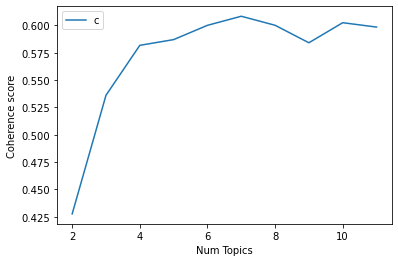

In [124]:
# Display coherence score vs number of topics plot
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [125]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num of Topics =", m, " has Coherence Value of", round(cv, 4))

Num of Topics = 2  has Coherence Value of 0.4276
Num of Topics = 3  has Coherence Value of 0.5361
Num of Topics = 4  has Coherence Value of 0.5818
Num of Topics = 5  has Coherence Value of 0.587
Num of Topics = 6  has Coherence Value of 0.6001
Num of Topics = 7  has Coherence Value of 0.6084
Num of Topics = 8  has Coherence Value of 0.6001
Num of Topics = 9  has Coherence Value of 0.5841
Num of Topics = 10  has Coherence Value of 0.6025
Num of Topics = 11  has Coherence Value of 0.5985


If the coherence score is continuously increasing, it may make better sense to use the elbow method and pick the model with lesser topics that gave the highest CV before it plateaus

#### 2.4.2.1 Exploring 5 topics

In [126]:
# Select the model and print the topics
optimal_model = model_list[3] # Based on the indices above, 5 topics appear to perform the best while still remaining in a meaningful range
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.034*"world" + 0.014*"human" + 0.013*"power" + 0.012*"earth" + '
  '0.011*"fight" + 0.009*"save" + 0.009*"war" + 0.008*"call" + 0.008*"battle" '
  '+ 0.007*"force"'),
 (1,
  '0.018*"year" + 0.010*"group" + 0.009*"team" + 0.008*"member" + 0.008*"lead" '
  '+ 0.008*"club" + 0.007*"face" + 0.007*"join" + 0.007*"begin" + '
  '0.006*"follow"'),
 (2,
  '0.035*"girl" + 0.020*"school" + 0.016*"make" + 0.016*"life" + 0.016*"day" + '
  '0.015*"love" + 0.013*"student" + 0.012*"friend" + 0.012*"work" + '
  '0.009*"dream"'),
 (3,
  '0.018*"short" + 0.015*"song" + 0.015*"special" + 0.013*"base" + '
  '0.013*"feature" + 0.012*"film" + 0.011*"include" + 0.011*"video" + '
  '0.011*"release" + 0.010*"show"'),
 (4,
  '0.023*"find" + 0.018*"live" + 0.015*"man" + 0.012*"life" + 0.012*"young" + '
  '0.012*"time" + 0.012*"family" + 0.011*"boy" + 0.011*"father" + '
  '0.010*"friend"')]


In [127]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.002293  0.368497       1        1  21.413236
2     -0.204150 -0.223489       2        1  20.671984
1      0.036971  0.099951       3        1  20.604415
4     -0.226563 -0.073984       4        1  20.366228
3      0.391448 -0.170974       5        1  16.944137, topic_info=        Term         Freq        Total Category  logprob  loglift
140    world  3903.000000  3903.000000  Default  30.0000  30.0000
742     girl  3807.000000  3807.000000  Default  29.0000  29.0000
576   school  2226.000000  2226.000000  Default  28.0000  28.0000
32      find  2865.000000  2865.000000  Default  27.0000  27.0000
302     live  1998.000000  1998.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
762   create   654.604419   723.037328   Topic5  -4.9256   1.6758
555     game   819.339306  1281.743525   Topic5  -4.7011   1.3278
482     real   427.010167   476.348583   Topic5  -5.3528   1.6659
2132    star   460.607414   595.265720   Topic5  -5.2771   1.5188
878    event   488.785750   730.888207   Topic5  -5.2177   1.3729

[374 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
867       2  0.999302        accept
755       5  1.006576       acclaim
142       3  1.001037        action
500       4  1.012619  action_packe
501       2  0.993776      addition
...     ...       ...           ...
85        4  0.000504          year
86        1  0.162051         young
86        2  0.154779         young
86        4  0.680925         young
86        5  0.001558         young

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

#### 2.4.2.2 Explore 3 topics 

In [128]:
# Select the model and print the topics
optimal_model = model_list[1] # 3 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.011*"short" + 0.009*"song" + 0.009*"special" + 0.008*"game" + '
  '0.008*"base" + 0.008*"feature" + 0.008*"follow" + 0.007*"film" + '
  '0.007*"include" + 0.007*"video"'),
 (1,
  '0.020*"girl" + 0.016*"life" + 0.014*"day" + 0.013*"friend" + 0.012*"school" '
  '+ 0.011*"find" + 0.011*"live" + 0.010*"time" + 0.009*"love" + 0.008*"make"'),
 (2,
  '0.021*"world" + 0.008*"human" + 0.008*"power" + 0.007*"call" + '
  '0.007*"earth" + 0.007*"mysterious" + 0.007*"fight" + 0.006*"city" + '
  '0.006*"battle" + 0.006*"order"')]


In [129]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.230469  0.284243       1        1  35.699080
1     -0.157364 -0.322357       2        1  35.136324
0      0.387833  0.038114       3        1  29.164595, topic_info=        Term         Freq        Total Category  logprob  loglift
140    world  3920.000000  3920.000000  Default  30.0000  30.0000
742     girl  3776.000000  3776.000000  Default  29.0000  29.0000
115     life  3052.000000  3052.000000  Default  28.0000  28.0000
736      day  2577.000000  2577.000000  Default  27.0000  27.0000
289   friend  2377.000000  2377.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1135   music   473.659603   473.659603   Topic3  -5.7922   1.2322
762   create   742.861823   756.164104   Topic3  -5.3422   1.2145
236   follow  1171.086452  1286.748551   Topic3  -4.8870   1.1380
50      make   916.650599  2388.005950   Topic3  -5.1319   0.2747
338     work   743.997698  1461.317912   Topic3  -5.3406   0.5572

[231 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1917      1  0.999173    ability
866       2  1.000179    academy
867       2  1.000283     accept
143       3  1.001347      adapt
342       3  0.999905  adventure
...     ...       ...        ...
85        1  0.542646       year
85        2  0.457157       year
754       2  0.989088      yearn
86        1  0.432357      young
86        2  0.567895      young

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

#### 2.4.2.3 Explore 4 topics

In [130]:
# Select the model and print the topics
optimal_model = model_list[2] # 4 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.027*"world" + 0.011*"human" + 0.011*"power" + 0.010*"earth" + '
  '0.009*"fight" + 0.008*"battle" + 0.007*"order" + 0.007*"call" + '
  '0.007*"force" + 0.007*"war"'),
 (1,
  '0.027*"girl" + 0.016*"school" + 0.012*"love" + 0.011*"make" + '
  '0.011*"student" + 0.009*"day" + 0.009*"life" + 0.008*"friend" + '
  '0.007*"year" + 0.007*"dream"'),
 (2,
  '0.014*"short" + 0.013*"song" + 0.012*"special" + 0.011*"game" + '
  '0.011*"base" + 0.010*"feature" + 0.010*"film" + 0.009*"include" + '
  '0.009*"video" + 0.009*"release"'),
 (3,
  '0.020*"find" + 0.015*"live" + 0.014*"young" + 0.014*"life" + 0.012*"time" + '
  '0.012*"man" + 0.010*"boy" + 0.010*"day" + 0.010*"friend" + 0.009*"family"')]


In [131]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.134545  0.372715       1        1  26.967569
1     -0.131167 -0.224950       2        1  26.101559
3     -0.157125 -0.143322       3        1  25.509434
2      0.422838 -0.004443       4        1  21.421438, topic_info=         Term         Freq        Total Category  logprob  loglift
742      girl  3811.000000  3811.000000  Default  30.0000  30.0000
140     world  3906.000000  3906.000000  Default  29.0000  29.0000
32       find  2872.000000  2872.000000  Default  28.0000  28.0000
576    school  2229.000000  2229.000000  Default  27.0000  27.0000
302      live  2002.000000  2002.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1135    music   464.350660   464.350660   Topic4  -5.5035   1.5408
3133     idol   461.010008   461.010008   Topic4  -5.5107   1.5408
830   version   426.489935   426.489935   Topic4  -5.5885   1.5408
236    follow   574.592184  1272.999784   Topic4  -5.2904   0.7453
338      work   524.482401  1454.954743   Topic4  -5.3817   0.5205

[296 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
866       2  1.000842    academy
141       4  0.987831  acclaimed
1         2  0.999763        act
7023      1  0.987835   activate
342       3  0.999371  adventure
...     ...       ...        ...
140       1  0.999984      world
85        1  0.480675       year
85        2  0.519129       year
86        1  0.002064      young
86        3  0.997518      young

[310 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

#### 2.4.2.4 Explore 6 topics

In [132]:
# Select the model and print the topics
optimal_model = model_list[4] # 6 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.017*"find" + 0.015*"young" + 0.013*"set" + 0.013*"boy" + 0.013*"father" + '
  '0.010*"man" + 0.010*"child" + 0.010*"mysterious" + 0.009*"return" + '
  '0.009*"adventure"'),
 (1,
  '0.034*"life" + 0.015*"begin" + 0.015*"people" + 0.012*"follow" + '
  '0.009*"world" + 0.009*"time" + 0.009*"end" + 0.008*"change" + '
  '0.008*"secret" + 0.007*"discover"'),
 (2,
  '0.032*"world" + 0.016*"human" + 0.016*"power" + 0.014*"earth" + '
  '0.014*"fight" + 0.011*"battle" + 0.011*"force" + 0.010*"war" + 0.008*"call" '
  '+ 0.008*"evil"'),
 (3,
  '0.021*"short" + 0.018*"song" + 0.017*"special" + 0.016*"base" + '
  '0.015*"feature" + 0.014*"film" + 0.013*"include" + 0.013*"video" + '
  '0.013*"release" + 0.012*"show"'),
 (4,
  '0.028*"day" + 0.024*"girl" + 0.017*"make" + 0.016*"time" + 0.015*"work" + '
  '0.010*"woman" + 0.010*"love" + 0.010*"live" + 0.010*"family" + '
  '0.009*"thing"'),
 (5,
  '0.025*"school" + 0.018*"girl" + 0.016*"student" + 0.013*"friend" + '
  '0.011*"year" + 0.011*"te

In [133]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.064936  0.342763       1        1  18.029088
1      0.119252  0.008768       2        1  17.314802
5      0.016484 -0.189377       3        1  17.153247
0      0.165183  0.086590       4        1  16.776898
4      0.078266 -0.277489       5        1  16.691102
3     -0.444122  0.028746       6        1  14.034862, topic_info=        Term         Freq        Total Category  logprob  loglift
115     life  3131.000000  3131.000000  Default  30.0000  30.0000
140    world  3922.000000  3922.000000  Default  29.0000  29.0000
742     girl  3845.000000  3845.000000  Default  28.0000  28.0000
736      day  2617.000000  2617.000000  Default  27.0000  27.0000
576   school  2258.000000  2258.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
246     part   687.750682   802.878356   Topic6  -4.6878   1.8088
300    japan   566.444964   740.259974   Topic6  -4.8819   1.6960
762   create   541.128988   709.459588   Topic6  -4.9276   1.6928
2132    star   455.687569   582.210569   Topic6  -5.0994   1.7186
555     game   409.274946  1286.175127   Topic6  -5.2069   0.8186

[456 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1917      1  0.327521    ability
1917      2  0.671500    ability
866       3  0.999305    academy
755       6  1.034201    acclaim
141       2  0.964113  acclaimed
...     ...       ...        ...
85        2  0.098406       year
85        3  0.520366       year
86        4  0.666064      young
86        5  0.334060      young
8062      5  1.000292        yuu

[511 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 1, 5, 4])

#### 2.4.2.5 Explore 8 topics

In [135]:
# Select the model and print the topics
optimal_model = model_list[6] # 8 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.055*"girl" + 0.032*"school" + 0.025*"love" + 0.021*"student" + '
  '0.016*"day" + 0.013*"life" + 0.012*"high_school" + 0.012*"friend" + '
  '0.011*"thing" + 0.010*"sister"'),
 (1,
  '0.020*"earth" + 0.014*"war" + 0.012*"force" + 0.012*"year" + 0.011*"fight" '
  '+ 0.010*"battle" + 0.010*"human" + 0.010*"planet" + 0.009*"robot" + '
  '0.009*"space"'),
 (2,
  '0.027*"world" + 0.018*"city" + 0.017*"time" + 0.016*"people" + '
  '0.016*"mysterious" + 0.015*"find" + 0.012*"begin" + 0.012*"call" + '
  '0.011*"discover" + 0.011*"event"'),
 (3,
  '0.027*"make" + 0.022*"work" + 0.017*"time" + 0.016*"friend" + '
  '0.011*"adventure" + 0.010*"day" + 0.009*"end" + 0.008*"follow" + '
  '0.008*"house" + 0.008*"train"'),
 (4,
  '0.030*"live" + 0.030*"life" + 0.025*"man" + 0.024*"young" + 0.019*"find" + '
  '0.019*"family" + 0.018*"boy" + 0.017*"father" + 0.015*"home" + '
  '0.015*"leave"'),
 (5,
  '0.019*"game" + 0.015*"year" + 0.015*"team" + 0.013*"member" + 0.012*"club" '
  '+ 0.011*"join"

In [136]:
# Visualize the topics with pyLDAvis (ignore warnings)
pyLDAvis.enable_notebook()
optimal_model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_vis, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.290453 -0.018136       1        1  13.215109
6      0.276213 -0.066527       2        1  13.098388
5      0.022929 -0.012652       3        1  12.913917
0     -0.241139 -0.138773       4        1  12.901091
2      0.025549 -0.058000       5        1  12.697142
4     -0.131577 -0.186105       6        1  12.640819
3     -0.186291  0.042867       7        1  12.070013
7     -0.056136  0.437327       8        1  10.463522, topic_info=             Term         Freq        Total Category  logprob  loglift
742          girl  3794.000000  3794.000000  Default  30.0000  30.0000
140         world  4003.000000  4003.000000  Default  29.0000  29.0000
576        school  2219.000000  2219.000000  Default  28.0000  28.0000
302          live  2007.000000  2007.000000  Default  27.0000  27.0000
115          life  3100.000000  3100.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4401      blu_ray   263.009493   263.009493   Topic8  -5.3554   2.2573
12200  commercial   273.086485   274.208785   Topic8  -5.3178   2.2532
488          show   743.682014   885.974003   Topic8  -4.3160   2.0822
246          part   436.333756   801.635096   Topic8  -4.8492   1.6490
762        create   318.432949   719.555018   Topic8  -5.1642   1.4421

[608 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
340       6  0.999767  abandon
1917      2  0.224490  ability
1917      3  0.139899  ability
1917      5  0.636054  ability
866       3  0.851071  academy
...     ...       ...      ...
85        5  0.073266     year
86        1  0.054144    young
86        2  0.106224    young
86        4  0.005157    young
86        6  0.834326    young

[742 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 1, 3, 5, 4, 8])

#### 2.4.2.6 Selecting 5 topics as optimal model based on above exploration

In [137]:
# Select the model and print the topics
optimal_model = model_list[3] # 5 topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.034*"world" + 0.014*"human" + 0.013*"power" + 0.012*"earth" + '
  '0.011*"fight" + 0.009*"save" + 0.009*"war" + 0.008*"call" + 0.008*"battle" '
  '+ 0.007*"force"'),
 (1,
  '0.018*"year" + 0.010*"group" + 0.009*"team" + 0.008*"member" + 0.008*"lead" '
  '+ 0.008*"club" + 0.007*"face" + 0.007*"join" + 0.007*"begin" + '
  '0.006*"follow"'),
 (2,
  '0.035*"girl" + 0.020*"school" + 0.016*"make" + 0.016*"life" + 0.016*"day" + '
  '0.015*"love" + 0.013*"student" + 0.012*"friend" + 0.012*"work" + '
  '0.009*"dream"'),
 (3,
  '0.018*"short" + 0.015*"song" + 0.015*"special" + 0.013*"base" + '
  '0.013*"feature" + 0.012*"film" + 0.011*"include" + 0.011*"video" + '
  '0.011*"release" + 0.010*"show"'),
 (4,
  '0.023*"find" + 0.018*"live" + 0.015*"man" + 0.012*"life" + 0.012*"young" + '
  '0.012*"time" + 0.012*"family" + 0.011*"boy" + 0.011*"father" + '
  '0.010*"friend"')]


topic 0: Anime about war or battles on earth

topic 1: Anime about membership in a club or group

topic 2: Anime about love story set in school

topic 3: Anime featuring songs, films or videos

topic 4: Anime about family life


## 2.5 Finding the dominant topic in each sentence (i.e. Assign topic number for each review)
Finding the topic number that has the highest percentage contribution in that document.

In [138]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data_lemmatized_nostop):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)




In [140]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Anime_Number', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



In [142]:
# Display dataframe
df_dominant_topic.tail(50)

,Anime_Number,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
17439,17439,0.0,0.3288,"world, human, power, earth, fight, save, war, ...",hidden deep in the ancient himalayan mountains...
17440,17440,0.0,0.2143,"world, human, power, earth, fight, save, war, ...",part of little mermaid series along with telep...
17441,17441,3.0,0.3562,"short, song, special, base, feature, film, inc...",doujin video produced by noted ero mangaka and...
17442,17442,2.0,0.4003,"girl, school, make, life, day, love, student, ...",mai and her gymnastics trainer are secretly in...
17443,17443,4.0,0.2437,"find, live, man, life, young, time, family, bo...",ikumi is an up and coming pop singer with mill...
17444,17444,3.0,0.3060,"short, song, special, base, feature, film, inc...",an erotic version of the classical japanese fo...
17445,17445,0.0,0.2475,"world, human, power, earth, fight, save, war, ...",take a mystical journey to an enchanted forest...
17446,17446,2.0,0.3310,"girl, school, make, life, day, love, student, ...",one day while walking home from school a young...
17447,17447,3.0,0.3177,"short, song, special, base, feature, film, inc...",one of the first erotic ova based in an origin...
17448,17448,3.0,0.2667,"short, song, special, base, feature, film, inc...",one of the first ova format adult anime based ...


## 2.6 Merging the topics into original df_positive dataframe

In [143]:
df_dominant_topic.shape

(17489, 5)

In [144]:
maldf5.shape

(17489, 84)

In [145]:
maldf6 = maldf5.reset_index()

In [146]:
maldf_final = pd.concat([maldf6, df_dominant_topic], axis=1)

In [147]:
maldf_final.head()

,index,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Air_Start,Air_End,Duration_Aired,Producer_0,Producer_1,Producer_2,Producer_3,Producer_4,Producer_5,Producer_6,Producer_7,Producer_8,Producer_9,Producer_10,Producer_11,Producer_12,Producer_13,Producer_14,Producer_15,Producer_16,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6,Anime_Number,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,2009-04-05,2010-07-04,1.25,Aniplex,Square Enix,Mainichi Broadcasting System,Studio Moriken,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bones,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.2993,"world, human, power, earth, fight, save, war, ...",in order for something to be obtained somethi...
1,1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-07,NaT,NaN,Production I.G,Dentsu,Mainichi Broadcasting System,Pony Canyon,Kodansha,Techno Sound,Pony Canyon Enterprise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAPPA,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.2820,"world, human, power, earth, fight, save, war, ...",gabi braun and falco grice have been training ...
2,2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN,Thriller,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-06,2011-09-14,0.44,Frontier Works,Media Factory,Movic,AT-X,Kadokawa Pictures Japan,Nitroplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,White Fox,Na

### 2.6.1 Assigning topics descriptions

In [149]:
#topic descriptions for the 5 topics
topic_mapping = {0:'Anime about war or battles on earth',
                 1:'Anime about membership in a club or group',
                 2:'Anime about love story set in school',
                 3:'Anime featuring songs, films or videos',
                 4:'Anime about family life'}

In [150]:
maldf_final['Topic_Category'] = maldf_final['Dominant_Topic'].map(topic_mapping)

In [151]:
maldf_final.tail()

,index,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Air_Start,Air_End,Duration_Aired,Producer_0,Producer_1,Producer_2,Producer_3,Producer_4,Producer_5,Producer_6,Producer_7,Producer_8,Producer_9,Producer_10,Producer_11,Producer_12,Producer_13,Producer_14,Producer_15,Producer_16,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6,Anime_Number,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic_Category
17484,17484,17484,34,Konbini Shoujo Z,https://myanimelist.net/anime/42383/Konbini_Sh...,NaN,NaN,コンビニ少女Z,OVA,NaN,Not yet aired,Not available,NaN,NaN,[],[],[],Visual novel,['Hentai'],30,Rx - Hentai,NaN,NaN,#14173,250,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hentai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,17484,0.0,0.2000,"world, human, power, earth, fight, save, war, ...",,Anime about war or battles on earth
17485,17485,17485,35,Manga Edo Erobanashi,https://myanimelist.net/anime/23677/Manga_Edo_...,NaN,"Glorious Manga Tale of Old Edo, Tale of Old Ed...",漫画江戸艶（えろ）ばなし,OVA,5.0,Finished Airing,"Apr 1, 1989 to Dec 27, 1989",NaN,NaN,['Group TAC'],[],[],Unknown,"['Comedy', 'Hentai', 'Historical']",45,Rx - Hentai,NaN,NaN,#12638,399,0,1989-04-01,1989-04-01,NaN,NaN,NaN,NaN,NaN,Several tales of old-time Tokyo from well know...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comedy,Hentai,Historical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989-04-01,1989-12-27,0.74,Group TAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,17485,2.0,0.2191,"girl, school, make, life, day, love, student, ...",several tales of old time tokyo from well know...,Anime about love story set in school
17486,17486,17486,36,Marudase Kintarou,https://myanimelist.net/anime/40845/Marudase_K...,NaN,Masaka no Kintarou,まるだせ金太狼,Movie,1.0,Finished Airing,"Dec 11, 2020",NaN,NaN,[],[],['Seven'],Manga,['Yaoi'],0,PG-13 - Teens 13 or older,NaN,NaN,#9061,1797,13,2020-12-11,NaN,NaN,['Masaka no Kintarou'],NaN,NaN,NaN,Makoto's grandfather was the principal of the ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yaoi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-11,NaT,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Seven,NaN,NaN,NaN,NaN,NaN,NaN,17486,2.0,0.3450,"girl, school, make, life, day, love, student, ...",makotos grandfather was the principal of the g...,Anime about love story set in school
17487,17487,17487,37,Misato-chan no Yume Nikki,https://myanimelist.net/anime/29994/Misato-cha...,NaN,NaN,みさとちゃんの夢日記,OVA,1.0,Finished Airing,"Jul 30, 1999",NaN,NaN,[],[],[],Unknown,['Hentai'],50,Rx - Hentai,NaN,NaN,#12178,480,0,1999-07-30,NaN,NaN,NaN,NaN,NaN,NaN,Based on an ero-game for PC released by the Ja...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hentai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-07-30,NaT,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,17487,3.0,0.2854,"short, song, special, base, feature, film, inc...",based on an ero game for pc released by the ja...,"Anime featuring songs, films or videos"
17488,17488,17488,38,Na Bbeun Sang Sa,https://myanimelist.net/anime/39731/Na_Bbeun_S...,NaN,Bad Boss,나쁜상사,Movie,1.0,Finished Airing,"Aug 7, 2018",NaN,NaN,[],[],[],Web manga,"['Slice of Life', 'Hentai', 'Drama', 'Romance'...",102,R+ - Mild Nudity,NaN,NaN,#11653,605,8,2018-08-07,NaN,NaN,NaN,NaN,NaN,NaN,Bad Boss is a femtai (hentai for women) from S...,

In [162]:
#save the dataframe results

maldf_final.to_csv('data/dataset_EDA_Topic_14022021.csv', index=False)

## 2.7 Generating word clouds

### 2.7.1 Word Cloud for Topic 0: Anime about war or battles on earth

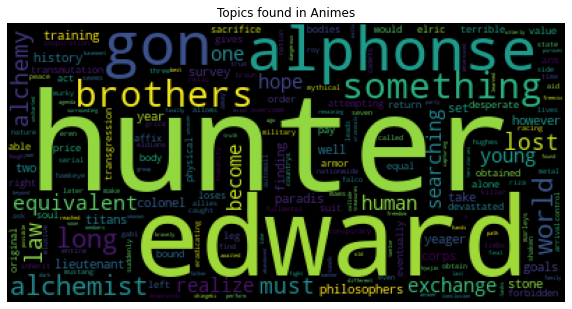

In [156]:
df_topic_0 = maldf_final[maldf_final['Dominant_Topic'] == 0]

text = df_topic_0['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")
plt.show()

### 2.7.2 Word Cloud for Topic 1: Anime about membership in a club or group

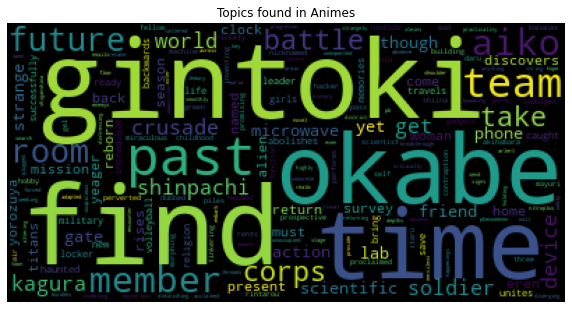

In [157]:
df_topic_1 = maldf_final[maldf_final['Dominant_Topic'] == 1]

text = df_topic_1['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")
plt.show()

### 2.7.3 Word Cloud for Topic 2: Anime about love story set in school

(-0.5, 399.5, 199.5, -0.5)

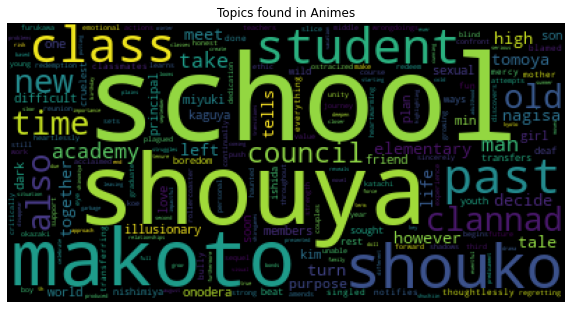

In [159]:
df_topic_2 = maldf_final[maldf_final['Dominant_Topic'] == 2]

text = df_topic_2['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")

### 2.7.4 Word Cloud for Topic 3: Anime featuring songs, films or videos

(-0.5, 399.5, 199.5, -0.5)

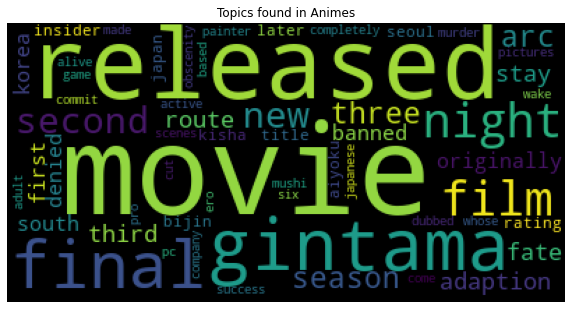

In [160]:
df_topic_3 = maldf_final[maldf_final['Dominant_Topic'] == 3]

text = df_topic_3['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")

### 2.7.5 Word Cloud for Topic 4: Anime about family life

(-0.5, 399.5, 199.5, -0.5)

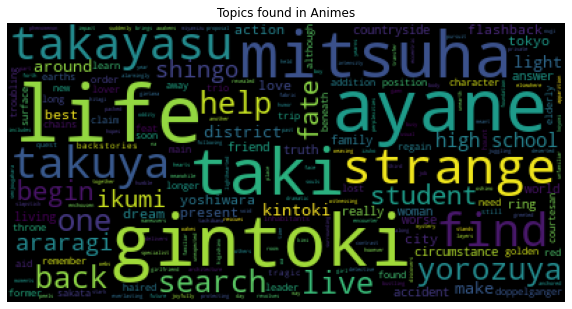

In [161]:
df_topic_4 = maldf_final[maldf_final['Dominant_Topic'] == 4]

text = df_topic_4['Text'].values

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stop_words).generate(str(text))

plt.figure(figsize=(10,10))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=2021))
plt.title('Topics found in Animes')
plt.axis("off")